## Environment preparation

In [1]:
import sys
sys.path.append('../src')

import os
import gc
import bcolz
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History
from itertools import chain
import random
import vgg16
import data_helper
from data_helper import Preprocessor


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Let pandas to print full name of data contents, instead of 'blah...'
pd.set_option('display.max_colwidth', -1)

tf.__version__

# Data input
destination_path = "../input/"
is_datasets_present = True

datasets_path = data_helper.get_jpeg_data_files_paths()
for dir_path in datasets_path:
    if os.path.exists(dir_path):
        is_datasets_present = True

if not is_datasets_present:
    print("Not all datasets are present.")
else:
    print("All datasets are present.")


All datasets are present.


Using TensorFlow backend.


## Loading data and trained weights

In [2]:
# Training and test data loading
train_jpeg_dir, test_jpeg_dir, train_csv_file, test_csv_file = data_helper.get_jpeg_data_files_paths()
labels_df = pd.read_csv(train_csv_file)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [3]:
labels_df_test = pd.read_csv(test_csv_file)
labels_df_test.head()

,image_name,tags
0,test_0.jpg,clear
1,test_10000.jpg,clear
2,test_10001.jpg,clear
3,test_10002.jpg,clear
4,test_10003.jpg,clear


There are 17 unique labels including {'blooming', 'partly_cloudy', 'clear', 'haze', 'road', 'cultivation', 'bare_ground', 'habitation', 'artisinal_mine', 'cloudy', 'conventional_mine', 'agriculture', 'primary', 'blow_down', 'water', 'slash_burn', 'selective_logging'}
0 train_70.jpg blooming blooming clear primary
1 train_22.jpg partly_cloudy partly_cloudy primary
2 train_3.jpg clear clear primary
3 train_43.jpg haze bare_ground haze
4 train_23.jpg road agriculture clear primary road
5 train_40.jpg cultivation agriculture clear cultivation primary
6 train_207.jpg bare_ground bare_ground clear primary road
7 train_92.jpg habitation agriculture clear habitation primary road
8 train_997.jpg artisinal_mine artisinal_mine clear primary road selective_logging water
9 train_37.jpg cloudy partly_cloudy primary
10 train_7224.jpg conventional_mine agriculture conventional_mine habitation partly_cloudy primary road
11 train_33.jpg agriculture agriculture cultivation partly_cloudy primary
12 train_

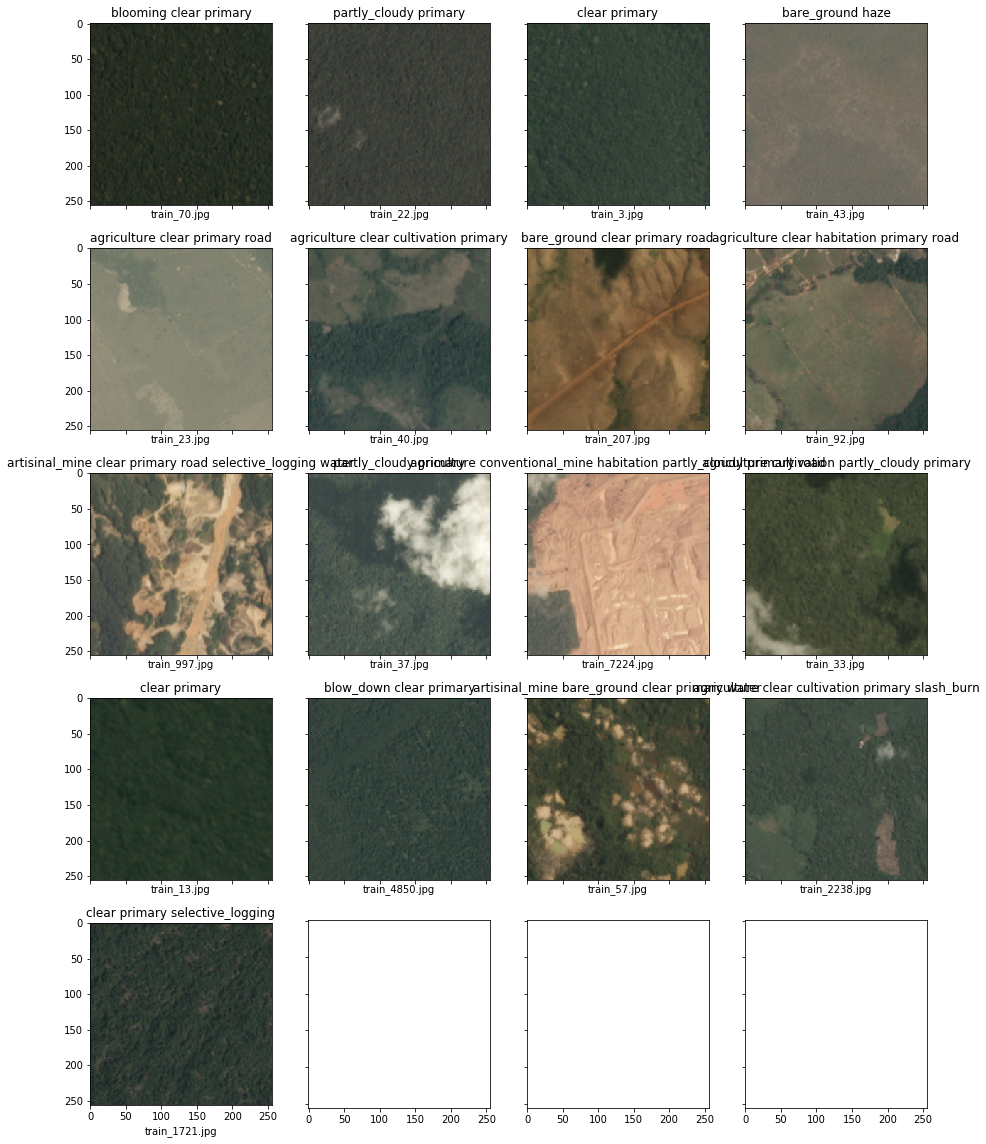

In [5]:
# Brief look at data
labels_list = list(chain.from_iterable([tags.split(" ") for tags in labels_df['tags'].values]))
labels_set = set(labels_list)
print("There are {} unique labels including {}".format(len(labels_set), labels_set))

images_title = [labels_df[labels_df['tags'].str.contains(label)].iloc[i]['image_name'] + '.jpg' 
                for i, label in enumerate(labels_set)]

labels_dict = dict()
for fn,tags in labels_df.values:
    labels_dict[fn] = tags
    
plt.rc('axes', grid=False)
_, axs = plt.subplots(5, 4, sharex='col', sharey='row', figsize=(15, 20))
axs = axs.ravel()

for i, (image_name, label) in enumerate(zip(images_title, labels_set)):
    img = mpimg.imread(train_jpeg_dir + '/' + image_name)

    
    labels=labels_dict[image_name[:-4]]
    print(i, image_name, label, labels)
    axs[i].imshow(img)
    axs[i].set_title('{}'.format(labels))
    axs[i].set_xlabel('{}'.format(image_name))
plt.show()


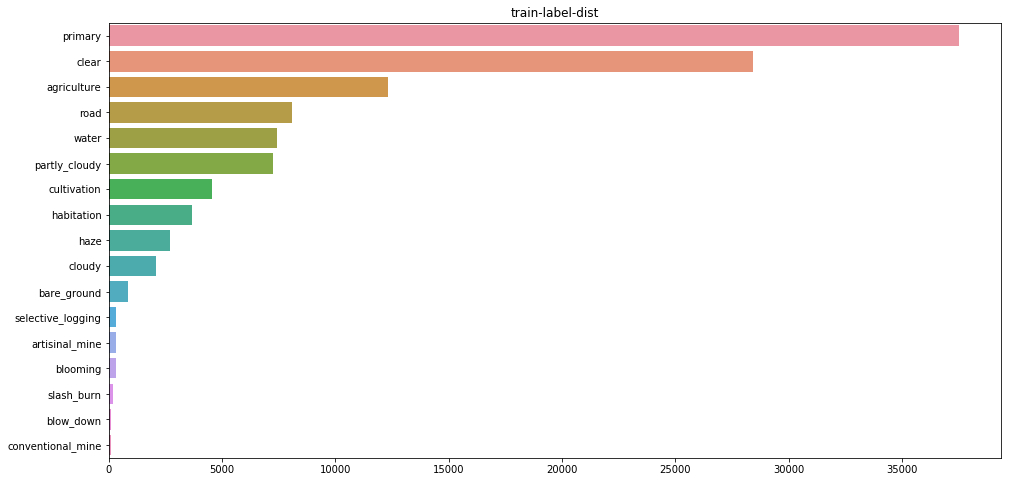

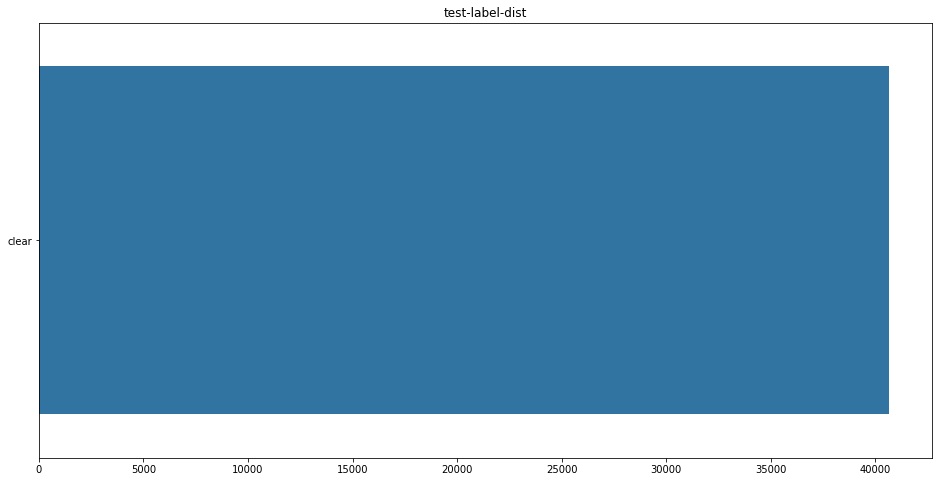

In [6]:
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.tools as tls
from collections import Counter, defaultdict
    
# Histogram of labeled data: train/test
labels = [labels_df['tags'].apply(lambda x: x.split(' ')),
          labels_df_test['tags'].apply(lambda x: x.split(' '))]
dist_titles = ['Distribution of training labels', 'Distribution of testing labels']
cooccur_titles = ['Co-occurence matrix of training labels', 'Co-occurence matrix of testing labels']
dist_fns = ['train-label-dist', 'test-label-dist']
cooccur_fns = ['train-cooccur-matrix', 'test-cooccur-matrix']

for idx in [0,1]: # Train vs. test

    counts = defaultdict(int)
    for l in sorted(labels[idx]):
        for l2 in l:
            counts[l2] += 1

#    data=[go.Bar(x=list(counts.keys()), y=list(counts.values()))]
#    layout=dict(height=800, width=800, title=dist_titles[idx])
#    fig=dict(data=data, layout=layout)
#    py.iplot(fig, filename=dist_fns[idx])

    tags_s = pd.Series(list(chain.from_iterable(labels[idx]))).value_counts()
    fig, ax = plt.subplots(figsize=(16, 8))
    sns.barplot(x=tags_s, y=tags_s.index, orient='h');
    plt.title(dist_fns[idx])
    plt.show()

    # Co-occurrence Matrix 
    com = np.zeros([len(counts)]*2)
    for i, l in enumerate(list(counts.keys())):
        for i2, l2 in enumerate(list(counts.keys())):
            c = 0
            cy = 0
            for row in sorted(labels[idx].values):
                if l in row:
                    c += 1
                    if l2 in row: cy += 1
            com[i, i2] = cy / c

    data=[go.Heatmap(z=com, x=list(counts.keys()), y=list(counts.keys()))]
    layout=go.Layout(height=800, width=800, title=cooccur_titles[idx])
    fig=dict(data=data, layout=layout)
    py.iplot(fig, filename=cooccur_fns[idx])



In [9]:
img_resize = (256, 256, 3)

# Split data into train/validation - percentage setting
validation_split_size = 0.2

# Data preprocessing
preprocessor = Preprocessor(train_jpeg_dir, train_csv_file, test_jpeg_dir, 
                                  img_resize[:2], validation_split_size)
preprocessor.init()

print("X_train/y_train length: {}/{}".format(len(preprocessor.X_train), len(preprocessor.y_train)))
print("X_val/y_val length: {}/{}".format(len(preprocessor.X_val), len(preprocessor.y_val)))
print("X_test/X_test_filename length: {}/{}".format(len(preprocessor.X_test), len(preprocessor.X_test_filename)))
preprocessor.y_map


100%|██████████| 8096/8096 [00:00<00:00, 219703.06it/s]


X_train/y_train length: 32383/32383
X_val/y_val length: 8096/8096
X_test/X_test_filename length: 40669/40669


{0: 'agriculture',
 1: 'artisinal_mine',
 2: 'bare_ground',
 3: 'blooming',
 4: 'blow_down',
 5: 'clear',
 6: 'cloudy',
 7: 'conventional_mine',
 8: 'cultivation',
 9: 'habitation',
 10: 'haze',
 11: 'partly_cloudy',
 12: 'primary',
 13: 'road',
 14: 'selective_logging',
 15: 'slash_burn',
 16: 'water'}

   ## Train the model

In [10]:
history = History()
callbacks = [history,
             EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, cooldown=0, min_lr=1e-7, verbose=1),
             ModelCheckpoint(filepath='weights/weights.best.hdf5', verbose=1, save_best_only=True,
                             save_weights_only=True, mode='auto')]

X_train, y_train = preprocessor.X_train, preprocessor.y_train
X_val, y_val = preprocessor.X_val, preprocessor.y_val


# ## Constructing the model
#----------------------------

model = vgg16.create_model(img_dim=img_resize)
model.summary()

batch_size = 32
train_steps = len(X_train) / batch_size
val_steps = len(X_val) / batch_size

train_generator = preprocessor.get_train_generator(batch_size)
validation_generator = preprocessor._get_validation_generator(batch_size)

model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics = ['accuracy'])

history = model.fit_generator(train_generator, train_steps, epochs=25, verbose=1,
                    validation_data=validation_generator, validation_steps=val_steps, callbacks=callbacks)


# ## Visualize Loss Curve

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.savefig("vgg16.losses.png")



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 3)       12        
_________________________________________________________________
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 17)                557073    
Total params: 15,271,773
Trainable params: 15,271,767
Non-trainable params: 6
_________________________________________________________________
Epoch 1/25
   2/1011 [..............................] - ETA: 7:13:34 - loss: 0.6106 - acc: 0.6857

KeyboardInterrupt: 

In [7]:
# Loading trained weights
model.load_weights("weights/weights.vgg16.best.hdf5")
print("Weights loaded")


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 170, 300, 3)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 170, 300, 3)       12        
_________________________________________________________________
vgg16 (Model)                (None, 5, 9, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 23040)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 207369    
Total params: 14,922,069
Trainable params: 14,922,063
Non-trainable params: 6
_________________________________________________________________
Weights loaded


## Evaluate

In [8]:
predictions, x_test_filename = vgg16.predict(model, preprocessor, batch_size=128)
print("Predictions shape: {}\nFiles name shape: {}\n1st predictions ({}) entry:\n{}".format(predictions.shape, 
                                    x_test_filename.shape, x_test_filename[0], predictions[0]))

# Setting threshold for each class
thresholds = [0.2] * len(labels_set)

predicted_labels = vgg16.map_predictions(preprocessor, predictions, thresholds)


267/266 [==============================] - 261s 977ms/step
Predictions shape: (34132, 9)
Files name shape: (34132,)
1st predictions (94eb8550-7a5f-54ef-b8ac-79e28d1fe2bf_video_B0_FC_60_13890) entry:
[1.1953971e-03 1.0000000e+00 4.2657550e-02 9.9999988e-01 8.7820599e-03
 7.4281997e-11 3.2986824e-03 1.3769413e-06 2.3363459e-01]


### Peep into predictions

In [1]:
# Look at predicted_labels vs. GT
labels_dict_test = dict()
for fn,tags in labels_df_test.values:
    labels_dict_test[fn] = tags
    
plt.rc('axes', grid=False)
_, axs = plt.subplots(5, 2, sharex='col', sharey='row', figsize=(15, 20))
axs = axs.ravel()

for j in range(10):
    i = random.randint(0, len(predicted_labels))
    img = mpimg.imread(test_jpeg_dir + '/' + x_test_filename[i] + '.jpg')
    
    labels=labels_dict_test[x_test_filename[i]]
    print(j, x_test_filename[i], predicted_labels[i], labels)
    axs[j].imshow(img)
    axs[j].set_title('Pred:{}'.format(predicted_labels[i]))
    axs[j].set_xlabel('GT:{}'.format(labels))
plt.show()

NameError: name 'labels_df_test' is not defined

In [10]:
batch_size=32
model.evaluate_generator(preprocessor._get_prediction_generator(batch_size), 
                         len(preprocessor.X_test_filename) / batch_size)

[0.7743801234420321, 0.8424124701087645]

In [11]:
model.metrics_names

['loss', 'acc']

In [2]:
#fbeta_score = vgg16.fbeta(model, X_val, y_val)
#print("fbeta_score (validation data) = ", fbeta_score)

#fbeta_score = fbeta_score()
#print("fbeta_score (test data) = ", fbeta_score)

tags_list = [None] * len(predicted_labels)
for i, tags in enumerate(predicted_labels):
    tags_list[i] = ' '.join(map(str, tags))

final_data = [[filename.split(".")[0], tags] for filename, tags in zip(x_test_filename, tags_list)]


final_df = pd.DataFrame(final_data, columns=['image_name', 'tags'])
print("Predictions rows:", final_df.size)
final_df.head()


final_df.to_csv('../submission_file.csv', index=False)

NameError: name 'predicted_labels' is not defined